In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [91]:
alaska_df = pd.read_excel("alaska.xlsx")
arx_df = pd.read_excel("arx.xlsx")
darius_df = pd.read_excel("darius.xlsx")

In [92]:
arx_df.head()

,ARX Income FIA,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Economatica
0,Em R$ Real,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Data,Cota,Patrimônio,Capt Líq,Captação,Resg Total,Resgate,Resg IR,Q Cotistas,Fonte
3,1999-07-01 00:00:00,1,2000,-,-,-,-,-,-,ANBIMA
4,1999-07-02 00:00:00,-,-,-,-,-,-,-,-,-


In [93]:
darius_df.head()

,Giant Darius Fc FI Mult,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Economatica
0,Em R$ Real,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Data,Cota,Patrimônio,Capt Líq,Captação,Resg Total,Resgate,Resg IR,Q Cotistas,Fonte
3,2018-11-01 00:00:00,1,5000000,5000000,5000000,0,0,0,1,CVM
4,2018-11-02 00:00:00,-,-,-,-,-,-,-,-,-


In [99]:
def clean_economatica(df):
    # Nome das colunas
    df.columns = df.iloc[2]
    
    # Eliminando cabeçalho
    df = df.iloc[3:]
    
    # Atribuindo data no indice
    dates = df.iloc[:,0]
    df = df.drop(["Data"], axis=1)
    df.index = dates
    
    # Transformando os dados em numericos
    df = df.iloc[:,:-1].apply(pd.to_numeric, errors='coerce').dropna()

    return df

In [100]:
alaska = clean_economatica(alaska_df)
arx = clean_economatica(arx_df)
darius = clean_economatica(darius_df)

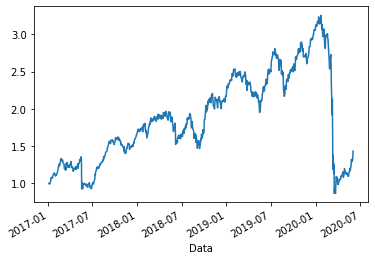

In [101]:
alaska.Cota.plot()

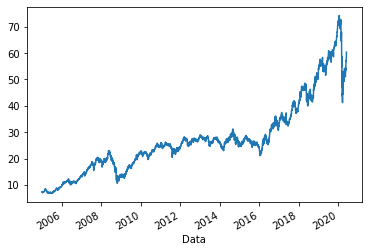

In [102]:
arx.Cota.plot()

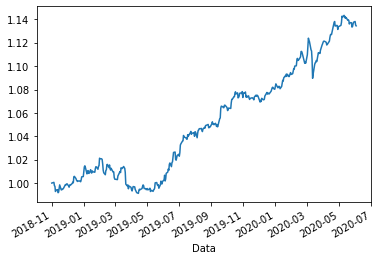

In [103]:
darius.Cota.plot()

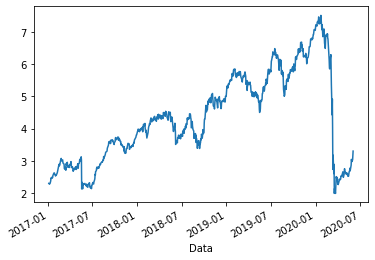

In [136]:
alaska.Cota[-1] / alaska.Cota[-2]  - 1

0.04047757613365044

In [142]:
def daily_returns (cumulative_returns):
    returns = []
    
    for i in range(len(cumulative_returns[::-1])):
        
        r = cumulative_returns[i] / cumulative_returns[i-1] - 1
        
        returns.append(r)
        
    return returns[::-1]

In [150]:
a = daily_returns(alaska.Cota.to_numpy())
d = daily_returns(darius.Cota.to_numpy())
ar = daily_returns(arx.Cota.to_numpy())

In [158]:
arx["daily_returns"] = ar
darius["daily_returns"] = d
alaska["daily_returns"] = a

In [210]:
bcff11 = yf.download("BCFF11.SA").pct_change()

[*********************100%***********************]  1 of 1 completed


In [212]:
returns = pd.concat([arx["daily_returns"],darius["daily_returns"],alaska["daily_returns"], bcff11["Close"]], axis=1)
returns.columns = ["ARX", "Darius","Alaska", "BCFF11"]

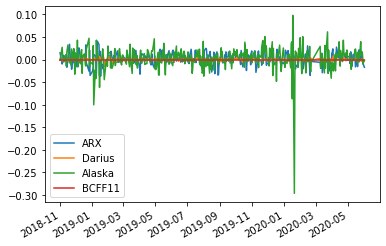

In [213]:
returns[:-2].dropna().plot()

In [233]:
def markowitz( returns, num_portfolios=5000, risk_free=0):

        exp_return = returns.mean()

        # vetores de dados
        portfolio_weights = []
        
        vols = []
        exp_returns = []
        sharpes = []
        
        # matriz de covariancia dos ativos
        cov_matrix = returns.cov()
        
        period, stocks = returns.shape

        # simulando diversos portfolios
        for i in range(num_portfolios):

            # construindo o vetor de pesos
            weights = np.random.uniform(0.2, 1, stocks)
            weights = weights/np.sum(weights)

            # calculando o retorno esperado da carteira
            returns = period * np.dot(weights, exp_return)
            exp_returns.append(returns)

            # calculando os desvio do portfolio
            vol =  np.sqrt(np.dot(np.dot(weights.T, cov_matrix * period), weights))
            vols.append(vol)

            # calculando o sharpe esperado
            sharpe = (returns - risk_free) / vol

            portfolio_weights.append(weights)
            sharpes.append(sharpe)

        index = pd.DataFrame(sharpes).idxmax()
        
        index = index.iloc[0]
        
        w = pd.DataFrame(portfolio_weights).iloc[index,:]
        
        return (exp_returns, vols, sharpe, index, w)

In [253]:
exp_returns, vols, sharpe, index, w = markowitz(returns, num_portfolios=5000000)

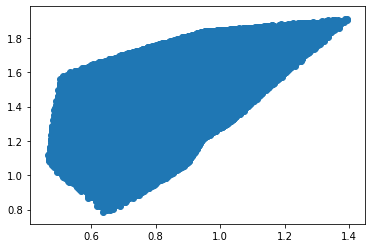

In [254]:
plt.scatter(vols, exp_returns)

In [255]:
w

0    0.135246
1    0.132612
2    0.124464
3    0.607678
Name: 4898007, dtype: float64

In [256]:
sharpe

1.8332917223483678

In [249]:
returns.cov()

,ARX,Darius,Alaska,BCFF11
ARX,4.283903e-04,0.000263,0.000330,2.645050e-07
Darius,2.627976e-04,0.000042,0.000094,0.000000e+00
Alaska,3.296280e-04,0.000094,0.001102,-3.740784e-06
BCFF11,2.645050e-07,0.000000,-0.000004,4.625914e-05


In [ ]:
0    0.126495
1    0.150132
2    0.130544
3    0.592829
Name: 108610, dtype: float64